In [ ]:
import pandas as pd
import json

In [48]:
brands=pd.read_json('brands.json', lines=True)
counts_by_barcode=brands.groupby('barcode').count()['_id']
counts_by_barcode[counts_by_barcode>1]

barcode
511111004790    2
511111204923    2
511111305125    2
511111504139    2
511111504788    2
511111605058    2
511111704140    2
Name: _id, dtype: int64

We see a few barcodes are used by multiple brands, this is an issue as it is the only potential join from the receipt items

In [90]:
data=[]
items=[]
missing_items=0
with open('receipts.json') as f:
    for line in f:
        data.append(json.loads(line))
for el in data:
    try:
        for item in el['rewardsReceiptItemList']:
            items.append({'receiptID':el['_id'], **item})
    except:
        missing_items += 1
print(f'there are {missing_items} records without an items record, which is {round(100*missing_items/len(data), 2)}% of all records')


there are 440 records without an items record, which is 39.32% of all records


In [50]:
items_df=pd.DataFrame(items)

In [57]:
percent_missing = items_df[['receiptID','barcode','description','itemPrice','quantityPurchased']].isnull().sum() * 100 / len(items_df)
missing_value_df = pd.DataFrame({'column_name': ['receiptID','barcode','description','itemPrice','quantityPurchased'],
                                 'percent_missing': percent_missing})
missing_value_df

,column_name,percent_missing
receiptID,receiptID,0.000000
barcode,barcode,55.481919
description,description,5.489123
itemPrice,itemPrice,2.506843
quantityPurchased,quantityPurchased,2.506843


We are missing a large percentage of barcodes as well, which means we do not know what was actually purchased if we wanted to line it back up with brands

In [113]:
receipts=pd.DataFrame(data)
percent_missing = receipts.isnull().sum() * 100 / len(receipts)
missing_value_df = pd.DataFrame({'column_name': receipts.columns,
                                 'percent_missing': percent_missing})
missing_value_df


,column_name,percent_missing
_id,_id,0.000000
bonusPointsEarned,bonusPointsEarned,51.385165
bonusPointsEarnedReason,bonusPointsEarnedReason,51.385165
createDate,createDate,0.000000
dateScanned,dateScanned,0.000000
finishedDate,finishedDate,49.240393
modifyDate,modifyDate,0.000000
pointsAwardedDate,pointsAwardedDate,52.010724
pointsEarned,pointsEarned,45.576408
purchaseDate,purchaseDate,40.035746


Total spend, purchasedItemCount, and points earned are all missing significant numbers, we are a rewards company so missing this data is pretty bad

Text(0.5, 0, 'points earned')

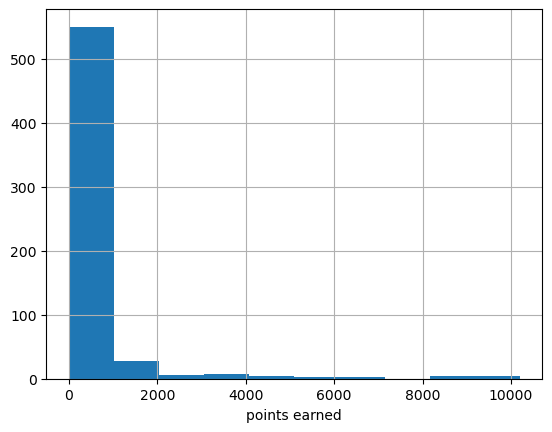

In [111]:
pe = receipts.pointsEarned.astype('float')
pe.hist().set_xlabel('points earned')

In [64]:
users=pd.read_json('users.json', lines=True)
print(f'''potential values for role (dataset said all should be consumer) {users.role.unique()}. 
this shows that fetch staff should be cleaned up before going into production''')

potential values for role (dataset said all should be consumer) ['consumer' 'fetch-staff']. 
this shows that fetch staff should be cleaned up before going into production


In [80]:
users_clean= users[users['role']=='consumer'].copy()
print(f'''potential values for signUpSource  {users_clean.signUpSource.unique()}. 
this shows that its a potential field to segment on, but there are null values''')

potential values for signUpSource  ['Email' 'Google' nan]. 
this shows that its a potential field to segment on, but there are null values


In [71]:
percent_missing = users_clean.isnull().sum() * 100 / len(users)
missing_value_df = pd.DataFrame({'column_name': users.columns,
                                 'percent_missing': percent_missing})
missing_value_df

,column_name,percent_missing
_id,_id,0.000000
active,active,0.000000
createdDate,createdDate,0.000000
lastLogin,lastLogin,12.525253
role,role,0.000000
signUpSource,signUpSource,1.818182
state,state,3.030303


In [ ]:
users_clean['_id'] = users_clean['_id'].astype(str)

In [87]:
print(f''' of all the records in the users table {100*len(users_clean._id.duplicated())/len(users_clean)} % are duplicated,
and aside from removing piotential sources of error, we can reduce the table size by {round(100*(1-(len(users_clean._id.unique())/len(users_clean))),2)}%
we should consider cleaning up before pushing to production''')

 of all the records in the users table 100.0 % are duplicated,
and aside from removing piotential sources of error, we can reduce the table size by 50.61%
we should consider cleaning up before pushing to production
